In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy as np
import seaborn as sns
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
import networkx as nx

In [2]:
from nmp.node import Node
from nmp.edge import Edge
from nmp.message_passer import MessagePasser
from nmp.state_updater import StateUpdater
from nmp.nmp_tools import get_lablesx, get_central_node, preprocess_graphx
from nmp.nmp_tools import run_message_passing, make_predictions, get_random_subgraphx

In [3]:
import os
import psutil
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from IPython.display import clear_output

process = psutil.Process(os.getpid())

## Необходимые приготовления(признаки и архитектуры)

Первое: объявляем функции для извлечения признаков из вершин и рёбер.

In [4]:
from typing import Callable

def node_feature_exctractor(node, node_shape: int):
    return np.array(
                    [
                        (node['features']['SX'] - 50001) / (20 * 1293.),
                        (node['features']['SY'] - 40011) / (20 * 1293.),
                        (node['features']['SZ'] - 36850.5) / (1293 * 57),
                        node['features']['TX'],
                        node['features']['TY'],
                        (node['features']['chi2'] - 1.5) / 1.5
                    ] + (node_shape - 6) * [0.]
                )

def edge_feature_exctractor(edge_uv, edge_shape: int):
    return np.array(
                    [
                        edge_uv['features']['dsx'],
                        edge_uv['features']['dsy'],
                        edge_uv['features']['dsz'],
                        edge_uv['features']['dsxProjLeft'],
                        edge_uv['features']['dsyProjLeft'],
                        edge_uv['features']['dsxProjRight'],
                        edge_uv['features']['dsyProjRight'],
                        (edge_uv['features']['r'] - 200) / 200

                    ] + (edge_shape - 8) * [0.]
                )

Второе: объявляем нейронки для пересылки сообщений, обновления состояния и readout.

In [5]:
class MessagePasserNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 32) # 32 / 64
        self.dropout_1 = nn.Dropout(p=0.01)
        self.nonlinear_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(32, 32)
        self.nonlinear_2 = nn.LeakyReLU()
        self.output = nn.Linear(32, output)

    def forward(self, x):
        x = self.nonlinear_1(self.dropout_1(self.layer_1(x)))
        x = self.nonlinear_2(self.layer_2(x))
        return self.output(x)
    
class StateUpdaterNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.gru = nn.GRUCell(input, output)
    
    def forward(self, x, hidden_state):
        hidden_state = self.gru(x, hidden_state)
        return hidden_state
    
    
class Readout(object):
    def __init__(self, input: int, output: int, readout: nn.Module):
        """
        :param scope:
        """
        self.input = input
        self.output = output
        self.readout = readout(input, output)

    def predict(self, node: 'Node'):
        return self.readout(node.state[None, :])
    
    
class ReadoutNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 32)
        self.mean = nn.Linear(32, output)
        self.sigma = nn.Linear(32, output)
        
    def forward(self, x):
        x = self.layer_1(x)
        
        mean = self.mean(x)
        sigma = self.sigma(x)
        
        mean = mean / (10 + mean.norm(dim=1, keepdim=True)).sqrt()
        sigma = sigma / (10 + sigma.norm(dim=1, keepdim=True)).sqrt()
        return mean[0], sigma[0]

## Инициализация функций

In [55]:
### shapes of nodes edges and messages
node_shape = 16 # tx, ty, chi2 + zeros
edge_shape = 16 # \delta_x \delta_y r
message_size = 16

### message passers for different steps
message_passer_first = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN)
message_passer_second = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN)
message_passers = {
    0: message_passer_first,
    1: message_passer_second
}

### state updater
state_updater = StateUpdater(input=message_size, output=node_shape, state_updater=StateUpdaterNN) 

### readout function
readout = Readout(input=node_shape, output=3, readout=ReadoutNN)

### optimizer
params_trainable = (
    list(message_passer_first.message_passer.parameters()) + 
    list(message_passer_second.message_passer.parameters()) + 
    list(readout.readout.parameters()) + 
    list(state_updater.state_updater.parameters()))
print('Number of trainable parameters'.format(sum([p.numel() for p in params_trainable])))
optimizer_params = optim.SGD(params_trainable, lr=1e-1)

Number of trainable parameters


Параметры засовываем в словарь, так проще.

In [56]:
params_mpnn = dict(
    optimizer_params=optimizer_params,
    node_shape=node_shape,
    edge_shape=edge_shape,
    readout=readout,
    message_passers=message_passers,
    state_updater=state_updater,
    node_feature_exctractor=node_feature_exctractor,
    edge_feature_exctractor=edge_feature_exctractor,
    order=-1,
    steps=2,
    margin=1.
)

## Загрузка данных

In [8]:
from glob import glob

In [9]:
glob('./data/brick_cleaned_*.pkl');

In [10]:
files = ['./data/brick_cleaned_5.pkl', './data/brick_cleaned_6.pkl', './data/brick_cleaned_7.pkl',
         './data/brick_cleaned_8.pkl']

In [11]:
graphx=nx.read_gpickle(files[0])

/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.2 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


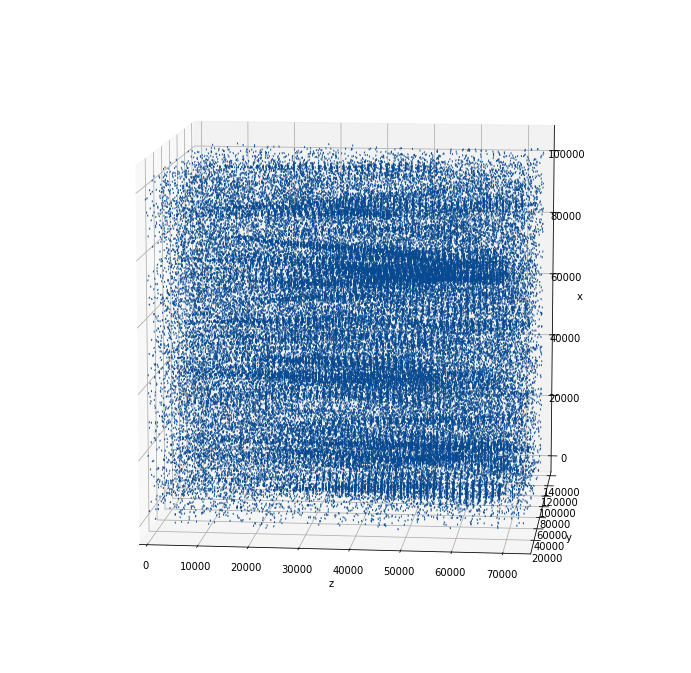

In [12]:
from tools.opera_tools import plot_graphx
plot_graphx(graphx)

In [13]:
from tools.opera_tools import *

train_data = []

for file in files:
    print(file)
    graphx=nx.read_gpickle(file)
    graphx_connected_components = []
    for connected_component in tqdm(nx.connected_components(nx.Graph(graphx)), leave=False):
        if len(connected_component) > 100:
            graphx_connected_components.append(graphx.subgraph(connected_component))
    for graphx_candidate in tqdm(graphx_connected_components, leave=False):
        lablesx_candidate = get_lablesx(graphx_candidate)
        if np.sum(np.unique(list(lablesx_candidate.values()), return_counts=True)[1][1:] > 150) > 1:
            train_data.append(nx.DiGraph(graphx_candidate))

./data/brick_cleaned_5.pkl


./data/brick_cleaned_6.pkl


./data/brick_cleaned_7.pkl


./data/brick_cleaned_8.pkl


In [35]:
def laplacian_clusters(nodes_predictions, true_labels):
    nodes_medians, nodes_log_b = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    clusters = dict()
    
    for label in labels:
        if label == 0.: continue
        if np.sum(true_labels==label) < 100: continue
            
        labeled_medians = nodes_medians[true_labels==label]
        labeled_log_b = nodes_log_b[true_labels==label]
        median = labeled_medians.median(dim=0)[0]
        b = torch.abs(labeled_medians - median).mean(dim=0) + (labeled_log_b.exp() * torch.exp(-torch.abs(labeled_medians - median) / labeled_log_b.exp())).mean(dim=0)
        clusters[label] = {
            'median': median, # 
            'b': b
        }
    
    return clusters


def gaussian_clusters(nodes_predictions, true_labels):
    nodes_means, nodes_log_std = nodes_predictions
    
    labels = np.unique(true_labels).astype(float)
    clusters = dict()
    
    for label in labels:
        if label == 0.: continue
        if np.sum(true_labels==label) < 100: continue
        
        labeled_means = nodes_means[(true_labels==label).astype(int)]
        labeled_log_std = nodes_log_std[(true_labels==label).astype(int)]
        
        mean = labeled_means.mean(dim=0)
        std = (labeled_means.std(dim=0).pow(2) + (2. * labeled_log_std).exp().mean(dim=0)).sqrt()
        clusters[label] = {
            'mean': mean,
            'std': std
        }
    del nodes_log_std, nodes_means
    return clusters

In [36]:
def loss_similar_laplacian_mean_div(nodes_predictions, true_labels, clusters):
    true_labels = np.array(true_labels)
    nodes_medians, nodes_log_b = list(zip(*nodes_predictions))
    nodes_medians = np.array(nodes_medians)
    nodes_log_b = np.array(nodes_log_b)
    labels = np.unique(true_labels)
    
    loss = 0.
    for label in clusters.keys():
        labeled_medians = torch.stack(list(nodes_medians[true_labels==label]))
        labeled_log_b = torch.stack(list(nodes_log_b[true_labels==label]))
        
        l = (labeled_medians - clusters[label]['median'].detach()).pow(2)
        loss = loss + l.sum(dim=1).mean()
    return loss

def loss_distinct_laplacian_mean_div(clusters, margin=1.):
    loss = 0.
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['median'] - clusters[label_1]['median']).pow(2)
            l = torch.relu(margin - l.sum().sqrt()).pow(2)
            loss = loss + l
    return loss


def loss_similar_laplacian_median_div(nodes_predictions, true_labels, clusters):
    true_labels = np.array(true_labels)
    nodes_medians, nodes_log_b = list(zip(*nodes_predictions))
    nodes_medians = np.array(nodes_medians)
    nodes_log_b = np.array(nodes_log_b)
    labels = np.unique(true_labels)
    
    loss = 0.
    for label in clusters.keys():
        labeled_medians = torch.stack(list(nodes_medians[true_labels==label]))
        labeled_log_b = torch.stack(list(nodes_log_b[true_labels==label]))
        
        l = (labeled_medians - clusters[label]['median'].detach()).abs()
        loss = loss + l.sum(dim=1).mean()
    return loss


def loss_distinct_laplacian_median_div(clusters, margin=1.):   
    loss = 0.
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['median'] - clusters[label_1]['median']).abs()
            l = torch.relu(margin - l.sum()).mean()
            loss = loss + l
    return loss

In [37]:
def loss_similar_gaussian_mean_div(nodes_predictions, true_labels, clusters):
    nodes_means, nodes_log_std = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    
    loss = 0.
    for label in clusters.keys():
        labeled_means = nodes_means[(true_labels==label).astype(int)]
        labeled_log_std = nodes_log_std[(true_labels==label).astype(int)]
        
        l = (labeled_means - clusters[label]['mean'].detach()).pow(2) # (labeled_log_std.exp() - clusters[label]['std'])**2 + 
        loss = loss + l.sum(dim=1).mean()
    del nodes_log_std, nodes_means
    return loss

def loss_distinct_gaussian_mean_div(clusters, margin=1.):
    loss = 0.
    N = len(clusters.keys())
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['mean'] - clusters[label_1]['mean']).pow(2) # (labeled_log_std.exp() - clusters[label]['std'])**2 + 
            l = torch.relu(margin - l.sum().sqrt()).pow(2)
            loss = loss + l
    return loss / 2



def loss_similar_gaussian_median_div(nodes_predictions, true_labels, clusters):
    nodes_means, nodes_log_std = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    
    loss = 0.
    for label in clusters.keys():
        labeled_means = nodes_means[(true_labels==label).astype(int)]
        labeled_log_std = nodes_log_std[(true_labels==label).astype(int)]
        
        l = (labeled_means - clusters[label]['mean'].detach()).abs() # (labeled_log_std.exp() - clusters[label]['std'])**2 + 
        loss = loss + l.sum(dim=1).mean()
    del nodes_log_std, nodes_means
    return loss


def loss_distinct_gaussian_median_div(clusters, margin=1.):
    loss = 0.
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['mean'] - clusters[label_1]['mean']).abs() # (labeled_log_std.exp() - clusters[label]['std'])**2 + 
            l = torch.relu(margin - l.sum())
            loss = loss + l
    return loss



In [71]:
def plot_clusters(nodes_predictions, true_labels, azim=47, elev=30):
    nodes_predictions = np.array(nodes_predictions[0].detach())
    true_labels = np.array(true_labels)
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    for cluster_id in np.unique(true_labels):
        if cluster_id == 0.:
            continue
        l = len(nodes_predictions[true_labels==cluster_id, 0])
        ax.scatter(
            nodes_predictions[true_labels==cluster_id, 0],
            nodes_predictions[true_labels==cluster_id, 1],
            nodes_predictions[true_labels==cluster_id, 2],
            alpha=0.4
        )
        
    plt.show()
    
def train_step(graphx, lablesx, optimizer_params, **params_mpnn):
    # reset
    for _, node in graphx.nodes(data=True):
        node['node_torch'].reset()
        
    # execute several steps of message passing with updates
    for step in range(params_mpnn['steps']):
        run_message_passing(graphx, step=step)

    # make predictions
    nodes_predictions, true_labels = make_predictions(graphx, **params_mpnn)

    # reset
    for _, node in graphx.nodes(data=True):
        node['node_torch'].reset()
    
    return nodes_predictions, true_labels

In [39]:
optimizer_params.param_groups[0]['lr'] = 1e-1

In [19]:
for graphx in train_data:
    preprocess_graphx(graphx, **params_mpnn)

[tensor(0.9997), tensor(0.9967), tensor(0.9972), tensor(2.9966), tensor(2.9967), tensor(0.9993), tensor(2.9972), tensor(0.9812), tensor(2.9957), tensor(0.9893), tensor(5.9857), tensor(0.9876), tensor(2.9893)]
19


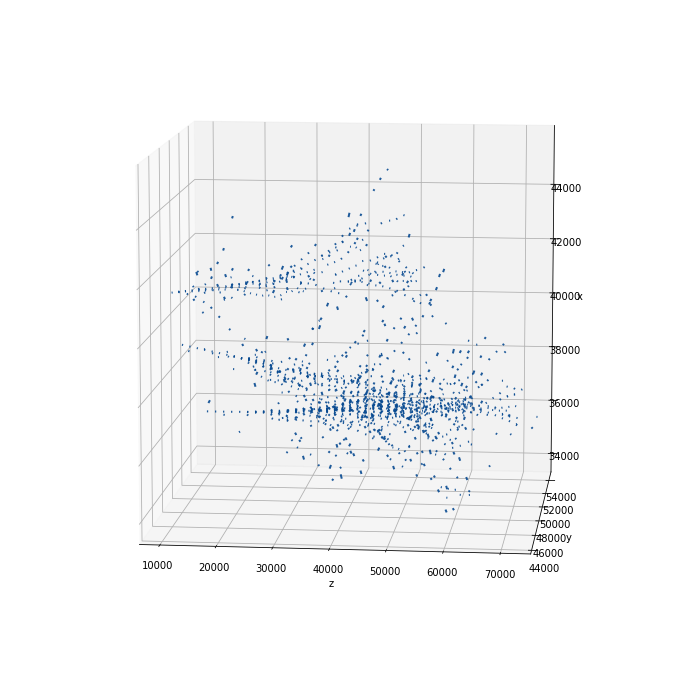

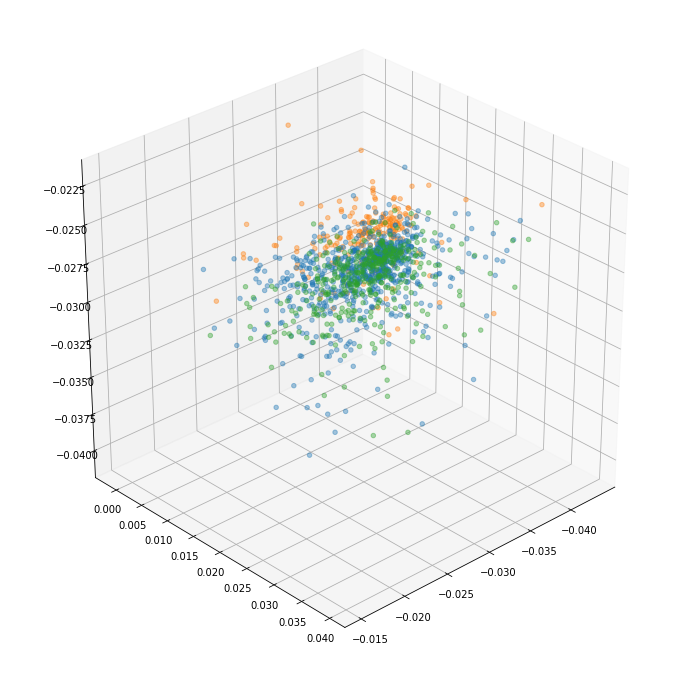

  1%|▏         | 13/1000 [1:42:33<129:46:18, 473.33s/it]

KeyboardInterrupt: 

In [72]:
from IPython.display import clear_output
from math import log
losses = []
for i in tqdm(range(1000)):
    k = np.random.choice(len(train_data))
    nodes_predictions, true_labels = train_step(
        graphx=train_data[k],
        lablesx=get_lablesx(train_data[k]),
        **params_mpnn
    )
        
    clusters = gaussian_clusters(nodes_predictions, true_labels)
    loss = (
        loss_similar_gaussian_mean_div(nodes_predictions, true_labels, clusters) + 
        loss_distinct_gaussian_mean_div(clusters, margin=1.)
    )
    #loss = loss_similar_gaussian_wasserstein(nodes_predictions, true_labels, clusters) * c
    optimizer_params.zero_grad()
    loss.backward()
    optimizer_params.step()
    
    #clear_output()
    losses.append(loss.detach())
    clear_output()
    print(losses)
    print(k)
    nodes_means, nodes_log_std = nodes_predictions
    plot_graphx(train_data[k])
    plot_clusters(nodes_predictions, true_labels)
    
    
    del nodes_predictions, true_labels, nodes_means, nodes_log_std

In [74]:
subgraph = train_data[k]

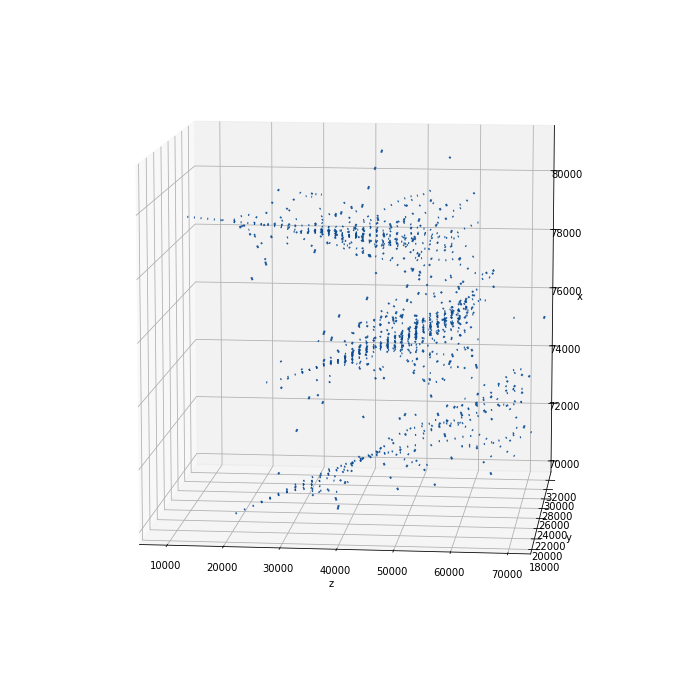

In [108]:
plot_graphx(subgraph)

In [ ]:
X = nodes_means.detach().numpy()

In [153]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, random_state=0, metric='precomputed', n_iter=5000)
X = np.zeros((1377, 1377))

nodes_list = list(subgraph.nodes())
nodes_idx_x = {key: index for index, key in enumerate(nodes_list)}

for i, j, edge in subgraph.edges(data=True):
    if edge['features']['r'] < 200:
        X[nodes_idx_x[i], nodes_idx_x[j]] = -edge['features']['r']
        X[nodes_idx_x[j], nodes_idx_x[i]] = -edge['features']['r']
        
        
X -= np.min(X)

trans_data = tsne.fit_transform(X).T


colors = []
for i in nodes_list:
    colors.append(subgraph.node[i]['signal'])

## Лосс функция